# A comparison between different fitting models using the Beysian Information Criterion

In [2]:
import igraph
import numpy as np
import matplotlib.pyplot as plt
import graph_functions
import scipy.stats as stats

from scipy.odr import ODR, Model, Data, RealData

In [3]:
%matplotlib inline
# %matplotlib qt5

# plt.style.use('ggplot')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"]})

In [4]:
# b[0] * x ** 0 + b[1] * x ** 1 + b[2] * x ** 2 + ...
def polynomial_series (beta, x):
    return sum([b * x ** i for i,b in enumerate(beta)])

In [5]:
def exponential_series (beta, x):
    return sum([b * np.exp(i * x) for i, b in enumerate(beta)])

In [6]:
def exponential (beta, x):
    return beta[1] * np.exp(beta[0] * x) + beta[2]

In [7]:
functions = [polynomial_series,exponential_series, exponential]

In [8]:
N = 10_000
m = 2

g = igraph.Graph.Barabasi(N,m)

In [9]:
d_np = np.array(g.degree())
c_np = np.array(g.closeness())

In [10]:
d_log = np.log(d_np)
c_inv = 1 / c_np

x,y,sdx,sdy = graph_functions.closeness_and_degree_to_x_y_bins(c_np, d_np)

In [11]:
polynomial_odrs = []
for i in range(10):
    model = Model(polynomial_series)
    data = RealData(x,y,sdx,sdy)

    # length of beta0 gives polynomial
    odr = ODR(data, model, [0] * (i + 1))
    odr.set_job(fit_type=0)
    output = odr.run()
    
    polynomial_odrs.append(output)

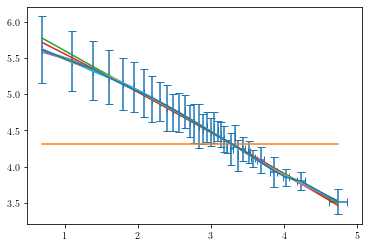

In [12]:
plt.errorbar(x,y,sdy,sdx,capsize=4,linestyle='none')

for o in polynomial_odrs:
    plt.plot(x,polynomial_series(o.beta,x))

In [29]:
def bic_val(f, beta):
    k = len(beta)
    residuals = list(map(
            lambda point: (point[1] - f(beta, point[0])),
            zip(d_log, c_inv))
        )
    mean, gaussian_std = stats.norm.fit(residuals)
    log_L_max = log_likelihood_gauss_regression(f, beta, gaussian_std, x,y)
    chi = sum(((y - polynomial_series(beta, x))/sdy)**2)
    # chi = graph_functions.chi_squared(x, y, f, beta)
    return k * np.log(len(x)) - 2 * log_L_max, log_L_max, len(beta), chi

In [30]:
def log_likelihood_gauss_regression(f, beta, gaussian_std, x, y):
    return sum([np.log(gaussian(y_i, f(beta, x_i), gaussian_std)) for x_i, y_i in zip(x,y)])

In [31]:
def gaussian(x, mean, std):
    return 1.0/(std * np.sqrt(2*np.pi)) * np.exp( -1/2 * ( ( (x - mean)/std ) ** 2) )

In [32]:
polynomial_bic_vals = list(map(lambda p: bic_val(polynomial_series, p.beta), polynomial_odrs))

In [35]:
for b in polynomial_bic_vals:
    print(b[2] - 1, 'th order --> \tBIC \t=', b[0], '\n\t\tln(L) \t=', b[1],'\n\t\tX^2 \t=', b[3], '\n\t\t-2ln(L)\t=', -2 * b[1])

0 th order --> 	BIC 	= 60.012473922118005 
		ln(L) 	= -28.228562930314297 
		X^2 	= 135.91213616622468 
		-2ln(L)	= 56.457125860628594
1 th order --> 	BIC 	= 12.15565166513572 
		ln(L) 	= -2.5224777710784463 
		X^2 	= 3.1710362995292507 
		-2ln(L)	= 5.044955542156893
2 th order --> 	BIC 	= 15.164180924955641 
		ln(L) 	= -2.2490683702437004 
		X^2 	= 3.109638533281697 
		-2ln(L)	= 4.498136740487401
3 th order --> 	BIC 	= 18.316247088261118 
		ln(L) 	= -2.0474274211517316 
		X^2 	= 2.7875208325292724 
		-2ln(L)	= 4.094854842303463
4 th order --> 	BIC 	= 21.77363923220272 
		ln(L) 	= -1.9984494623778255 
		X^2 	= 2.774604029782538 
		-2ln(L)	= 3.996898924755651
5 th order --> 	BIC 	= 25.341943466679517 
		ln(L) 	= -2.0049275488715175 
		X^2 	= 2.7613195594354503 
		-2ln(L)	= 4.009855097743035
6 th order --> 	BIC 	= 28.90029939658125 
		ln(L) 	= -2.006431483077679 
		X^2 	= 2.734992193307597 
		-2ln(L)	= 4.012862966155358
7 th order --> 	BIC 	= 32.44793545582152 
		ln(L) 	= -2.002575481953

05-11: Likelihood is still weird. 

## Deviance
$$D_{\mathcal{M}}=-2 \log \left(\frac{L_{\mathcal{M}}}{L_{\mathcal{S}}}\right)=-2\left(\log L_{\mathcal{M}}-\log L_{\mathcal{S}}\right)$$

In [18]:
# ODR cannot fit enought parameters to the thing.... dies after like 15
model = Model(polynomial_series)
data = RealData(x,y,sdx,sdy)

# length of beta0 gives polynomial
odr = ODR(data, model, [6, -0.5] + [1] * 15)
odr.set_job(fit_type=0)

saturated_odr = odr.run()

(3.0, 6.5)

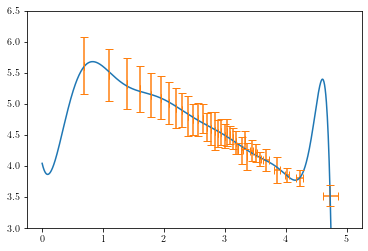

In [19]:
x_line = np.linspace(0,5,1000)
plt.plot(x_line,polynomial_series(saturated_odr.beta, x_line))
plt.errorbar(x,y,sdy,sdx,capsize=4,linestyle='none')
plt.ylim((3,6.5))

In [20]:
saturated_odr.beta

array([ 4.03977685e+00, -4.21758277e+00,  2.79828923e+01, -3.37917246e+01,
       -7.53318971e+00,  5.01020281e+01, -5.21184025e+01,  2.99471450e+01,
       -1.11651817e+01,  2.60293737e+00, -1.41552588e-01, -1.70584678e-01,
        7.72209338e-02, -1.69867222e-02,  2.10481389e-03, -1.37105079e-04,
        3.51208825e-06])

In [21]:
p = np.polyfit(x,y,deg=len(x)-1, full=True)
len(p[0])

35

(3.0, 6.0)

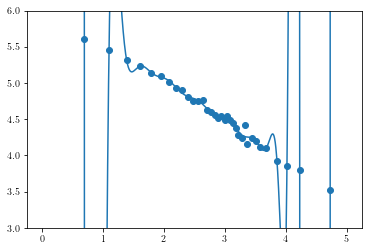

In [22]:
plt.plot(x_line, polynomial_series(np.flip(p[0]), x_line))
plt.scatter(x,y)
plt.ylim((3,6))

In [23]:
saturated_bic = bic_val(polynomial_series, np.flip(p[0]))

In [24]:
print(saturated_bic[2] - 1, 'th order --> \tBIC \t=', saturated_bic[0], '\n\t\t\tln(L) \t=', saturated_bic[1])

34 th order --> 	BIC 	= 792.1431149311516 
			ln(L) 	= -333.85296638951104


In [25]:
deviance = -2 * (saturated_bic[1] - polynomial_bic_vals[1][1])

In [26]:
print(f'Deviance: {deviance}')

Deviance: 662.6609772368652


Deviance is way to large? At least the log likelihood is way smaller for the saturated model than for the normal one, indicating that there's something suspicous going on...